Deep Learning project:
intestine cancer segmentation
phase 1

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import re
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import random
import plotly.express as px
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

# Data Preparation
- Reading 16 bit images
- Generating segmentation masks by decoding RLE 


In [ ]:
data = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")

In [ ]:
data.head(10)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
5,case123_day20_slice_0002,stomach,NaN
6,case123_day20_slice_0003,large_bowel,NaN
7,case123_day20_slice_0003,small_bowel,NaN
8,case123_day20_slice_0003,stomach,NaN
9,case123_day20_slice_0004,large_bowel,NaN


In [ ]:
data.nunique()

id              38496
class               3
segmentation    33899
dtype: int64

# Dataset Structuring
- Create a pivot table to get the segmentation RLEs against each organ. i.e. stomach and small & large bowel
- This pivot table will not contain those records for which segmentation masks are not available as we are using the 'max' aggregation
- Filter out the records without the segmentation masks and concatenate the pivot table dataframe and this dataframe

In [ ]:
df1 = data.pivot_table(values='segmentation',index='id',columns='class',aggfunc='max').reset_index()

In [ ]:
df1

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...
...,...,...,...,...
16585,case9_day22_slice_0115,38022 2 38380 7 38739 9 39099 10 39295 6 39459...,21360 7 21718 10 22077 12 22435 15 22788 1 227...,NaN
16586,case9_day22_slice_0116,38021 4 38379 8 38739 10 38938 2 39099 10 3929...,21361 3 21718 9 22076 12 22435 14 22794 17 231...,NaN
16587,case9_day22_slice_0117,38020 7 38379 10 38738 12 38936 4 39098 12 392...,21717 8 22076 11 22434 15 22791 20 23149 25 23...,NaN
16588,case9_day22_slice_0118,37661 5 38019 10 38378 12 38738 12 39097 14 39...,21359 6 21717 10 22074 15 22431 20 22790 23 23...,NaN


In [ ]:
df2 = data.drop_duplicates(subset=['id'])

In [ ]:
df3 = pd.DataFrame(columns=['id','large_bowel','small_bowel','stomach'])
df3['id'] = df2[~df2['id'].isin(df1['id'])].id.values

## Restructured Dataframe: After Concatenation

In [ ]:
data = pd.concat([df1,df3])
data.reset_index(inplace=True,drop=True)
data.head(10)

,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...
5,case101_day20_slice_0071,NaN,NaN,28117 12 28382 16 28647 18 28912 21 29177 24 2...
6,case101_day20_slice_0072,NaN,NaN,27053 9 27317 14 27582 16 27847 19 28112 22 28...
7,case101_day20_slice_0073,NaN,NaN,26786 9 27050 14 27314 18 27579 21 27844 23 28...
8,case101_day20_slice_0074,31080 6 31345 8 31610 10 31876 10 32142 10 324...,NaN,26517 10 26781 16 27046 19 27311 22 27577 23 2...
9,case101_day20_slice_0075,30813 7 31078 10 31343 11 31609 12 31875 12 32...,NaN,25984 12 26249 15 26514 18 26779 20 27044 23 2...


## Get Image Data
- Get Case ID, Day, Slice number
- Get the dimensions of the image
- Get the filepath of each image

In [ ]:
data['case'] = data['id'].apply(lambda x: re.findall("\d+",x)[0])
data['day'] = data['id'].apply(lambda x: re.findall("\d+",x)[1])
data['slice'] = data['id'].apply(lambda x: re.findall("\d+",x)[2])

## Patient Data
- Case: Unique ID of a patient
- Day: Patients are expected to get their MRI scans done on multiple days
- Slice: Multiple images of several MRI scans done on a specific day

In [ ]:
data

,id,large_bowel,small_bowel,stomach,case,day,slice
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...,101,20,0066
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...,101,20,0067
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,101,20,0068
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...,101,20,0069
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...,101,20,0070
...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,NaN,NaN,NaN,30,0,0140
38492,case30_day0_slice_0141,NaN,NaN,NaN,30,0,0141
38493,case30_day0_slice_0142,NaN,NaN,NaN,30,0,0142
38494,case30_day0_slice_0143,NaN,NaN,NaN,30,0,0143


## Image Path and Dimensions

In [ ]:
path_df = pd.DataFrame(data=glob("../input/uw-madison-gi-tract-image-segmentation/train/*/*/*/*"),columns=['filepath'])

In [ ]:
path_df['case'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[1])
path_df['day'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[2])
path_df['slice'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[3])
path_df['width'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[4])
path_df['height'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[5])
path_df['pixel_x'] = path_df['filepath'].apply(lambda x: re.findall("\d+\.\d+",x)[0])
path_df['pixel_y'] = path_df['filepath'].apply(lambda x: re.findall("\d+\.\d+",x)[1])

In [ ]:
data = data.merge(path_df, how='left', on=['case','day','slice'])

In [ ]:
data.sort_values(by=['case','day','slice'],ignore_index=True, inplace=True)
data

,id,large_bowel,small_bowel,stomach,case,day,slice,filepath,width,height,pixel_x,pixel_y
0,case101_day20_slice_0001,NaN,NaN,NaN,101,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
1,case101_day20_slice_0002,NaN,NaN,NaN,101,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
2,case101_day20_slice_0003,NaN,NaN,NaN,101,20,0003,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
3,case101_day20_slice_0004,NaN,NaN,NaN,101,20,0004,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
4,case101_day20_slice_0005,NaN,NaN,NaN,101,20,0005,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case92_day0_slice_0140,NaN,NaN,NaN,92,0,0140,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
38492,case92_day0_slice_0141,NaN,NaN,NaN,92,0,0141,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
38493,case92_day0_slice_0142,NaN,NaN,NaN,92,0,0142,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
38494,case92_day0_slice_0143,NaN,NaN,NaN,92,0,0143,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50


## Removal of Poorly Annotated Data
- In the dicussions forum some of the cases were spotted out as poorly annotated
- We will remove these datapoints from our records

In [ ]:
data['width'] = data['width'].astype(int)
data['height'] = data['height'].astype(int)

data = data[(data['case']!='7') & (data['day']!='0')].reset_index(drop=True)
data = data[(data['case']!='81') & (data['day']!='30')].reset_index(drop=True)
data = data[(data['case']!='138') & (data['day']!='00')].reset_index(drop=True)

In [ ]:
data

,id,large_bowel,small_bowel,stomach,case,day,slice,filepath,width,height,pixel_x,pixel_y
0,case101_day20_slice_0001,NaN,NaN,NaN,101,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
1,case101_day20_slice_0002,NaN,NaN,NaN,101,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
2,case101_day20_slice_0003,NaN,NaN,NaN,101,20,0003,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
3,case101_day20_slice_0004,NaN,NaN,NaN,101,20,0004,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
4,case101_day20_slice_0005,NaN,NaN,NaN,101,20,0005,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...
25659,case90_day29_slice_0140,NaN,NaN,NaN,90,29,0140,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
25660,case90_day29_slice_0141,NaN,NaN,NaN,90,29,0141,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
25661,case90_day29_slice_0142,NaN,NaN,NaN,90,29,0142,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
25662,case90_day29_slice_0143,NaN,NaN,NaN,90,29,0143,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50


# Visualization: MRI Scans

In [ ]:
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype("float32")
    return img

In [ ]:
def display_images(temp_df):
    temp_df = temp_df.sample(15).reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    for i in range(15):
        plt.subplot(5 , 5, i+1)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(temp_df.loc[i,'filepath'])
        plt.imshow(image, cmap='gray')
        plt.title(f"{temp_df.loc[i,'id']}")

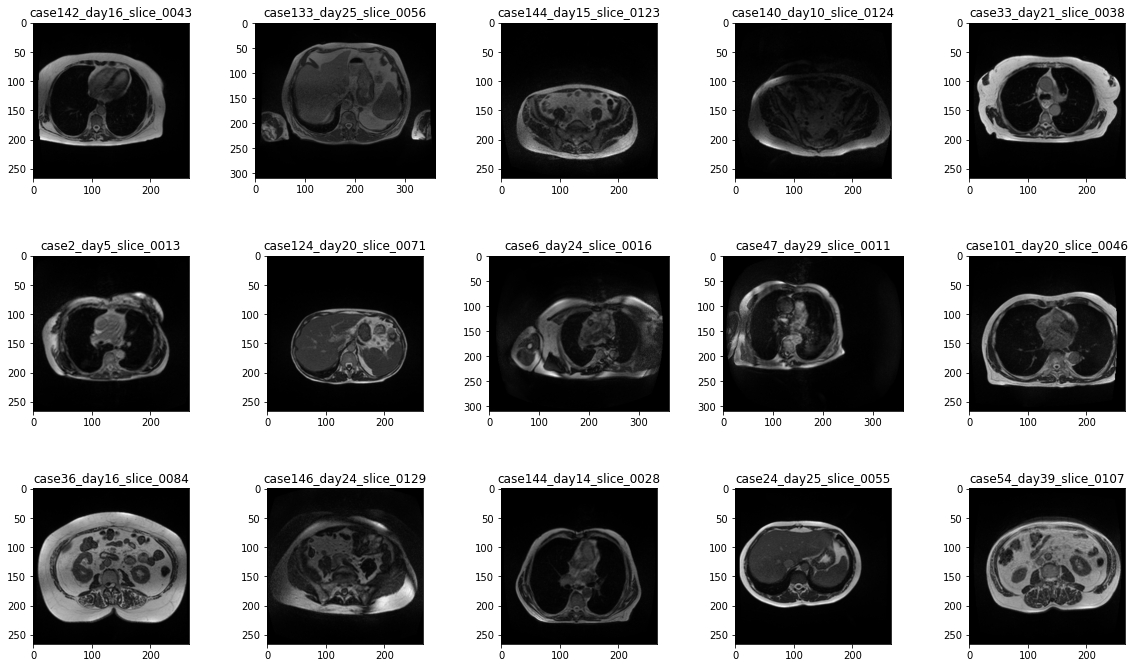

In [ ]:
display_images(data)

# RLE Decoding
- Do check out **Andrada Olteanu's (Grandmaster)** Notebook on some additional preparation steps as well, the RLE decoding part has been referenced from her notebook
- Notebook Link: https://www.kaggle.com/code/andradaolteanu/aw-madison-eda-in-depth-mask-exploration

![image.png](attachment:459f8582-acdd-4fcf-a59f-851ad01f279c.png)

In [ ]:
def mask_from_rle(rle, shape):
    
    if type(rle) == float: # if nan
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)

    segm = np.asarray(rle.split(), dtype=int)
    start_point = segm[0::2] - 1
    length_point = segm[1::2]
    end_point = start_point + length_point
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 255

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

# Visualization: Segmentation Masks 
- For now lets visualize and see the segmentation masks individually
- We will put them together in single RGB mask next

In [ ]:
def visual(temp_df,size):
    temp_df = temp_df.sample(size).reset_index(drop=True)
    for index in range(size):
        plt.figure(figsize=(20,10))
        image = read_img(temp_df['filepath'].iloc[index])
        plt.subplot(1,4,1)
        plt.imshow(image)
        plt.title("MRI Scan")
        plt.subplot(1,4,2)
        plt.imshow(mask_from_rle(temp_df['large_bowel'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Large Bowel")
        plt.subplot(1,4,3)
        plt.imshow(mask_from_rle(temp_df['small_bowel'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Small Bowel")
        plt.subplot(1,4,4)
        plt.imshow(mask_from_rle(temp_df['stomach'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Stomach")

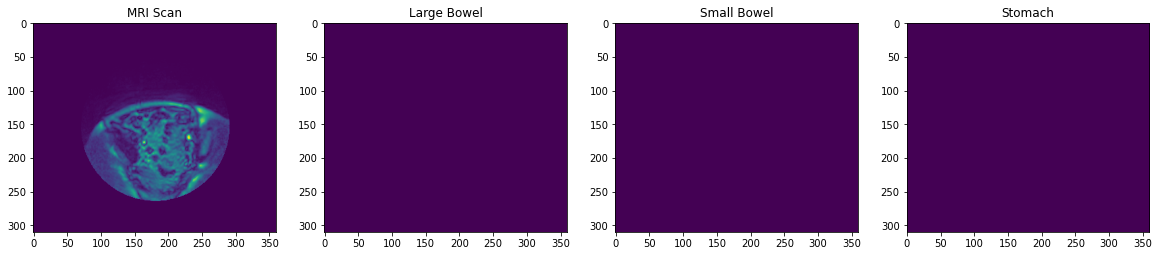

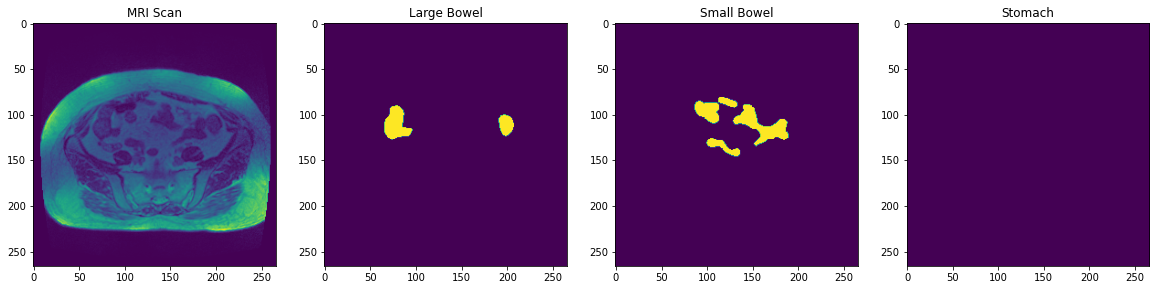

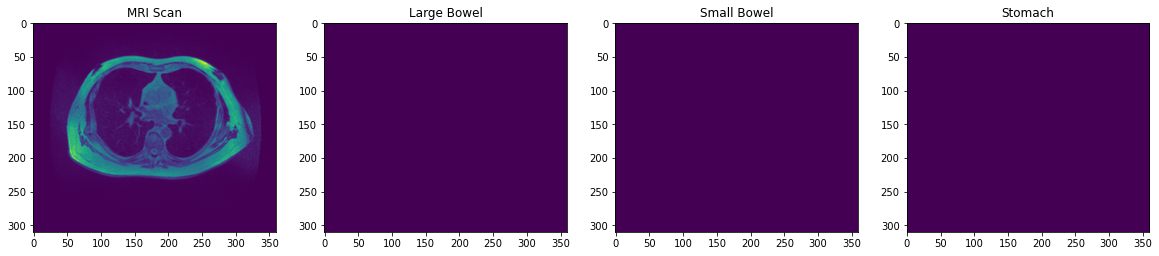

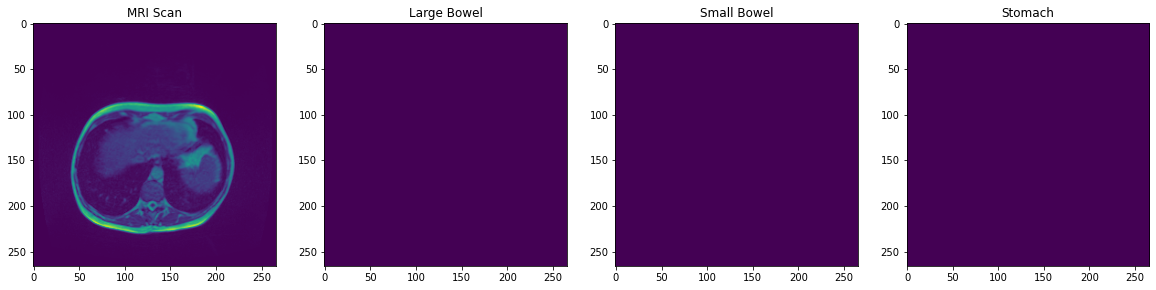

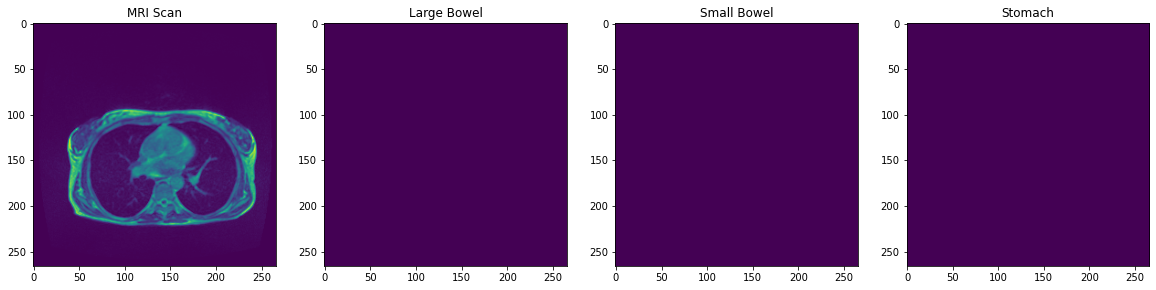

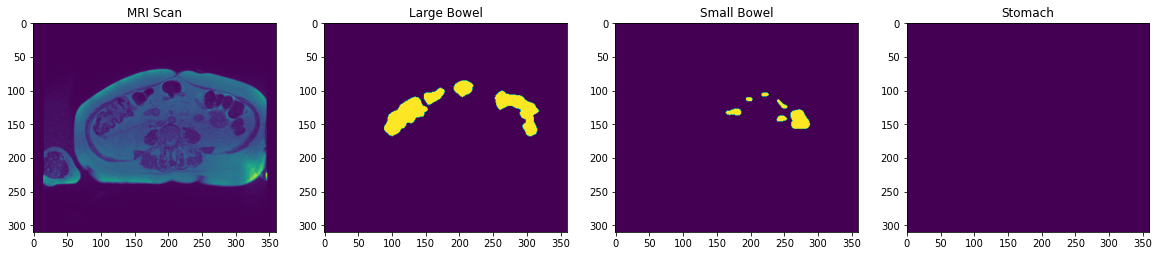

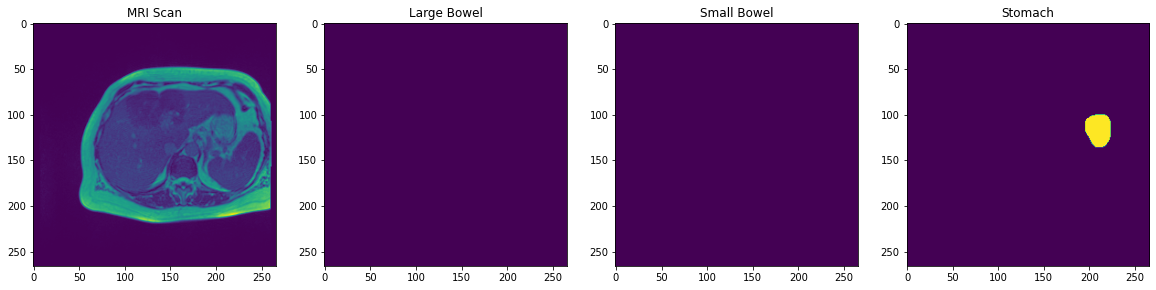

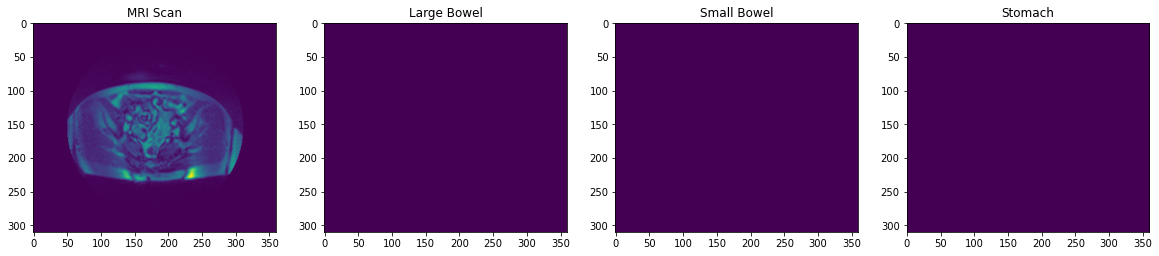

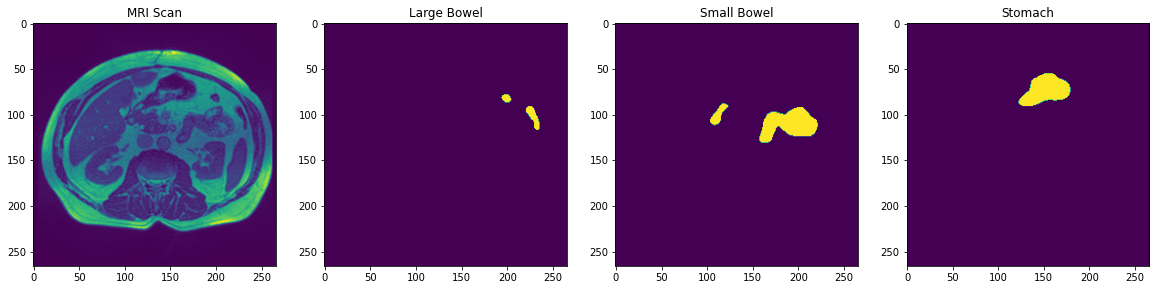

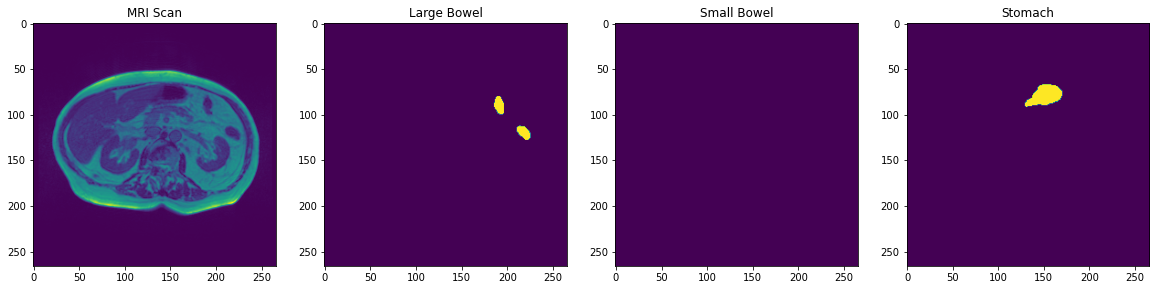

In [ ]:
visual(data,10)

# Visualization: RGB Masks

In [ ]:
def RGBMask(record):
    
    shape = (record['height'], record['width'], 3)
    mask = np.zeros(shape, dtype=np.uint8)
    
    small = mask_from_rle(record['small_bowel'],(record['height'],record['width']))
    large = mask_from_rle(record['large_bowel'],(record['height'],record['width']))
    stomach = mask_from_rle(record['stomach'],(record['height'],record['width']))
    
    mask[...,0] = large
    mask[...,1] = small
    mask[...,2] = stomach
    
    return mask

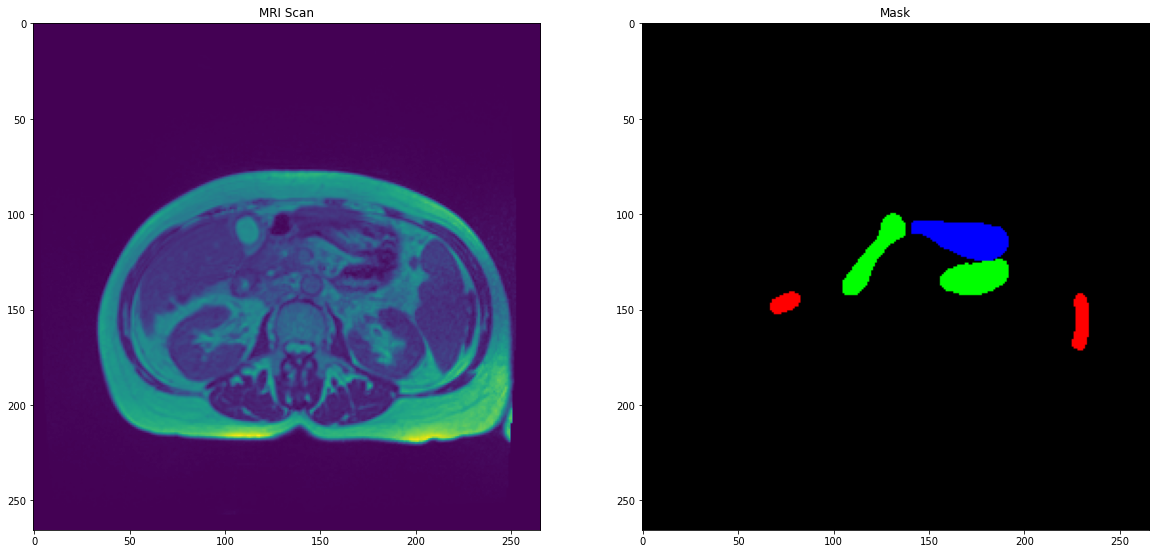

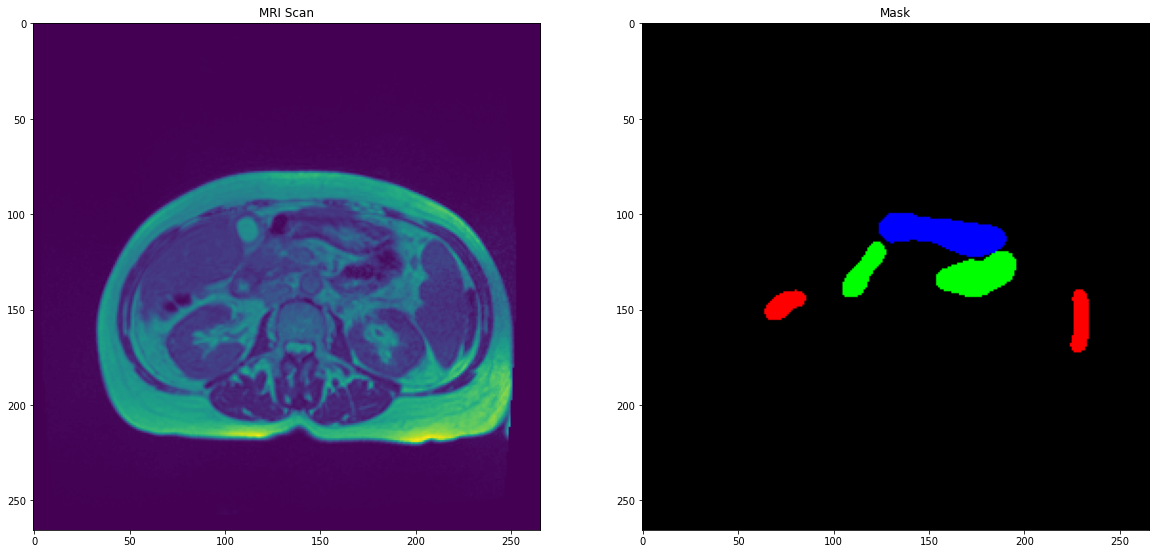

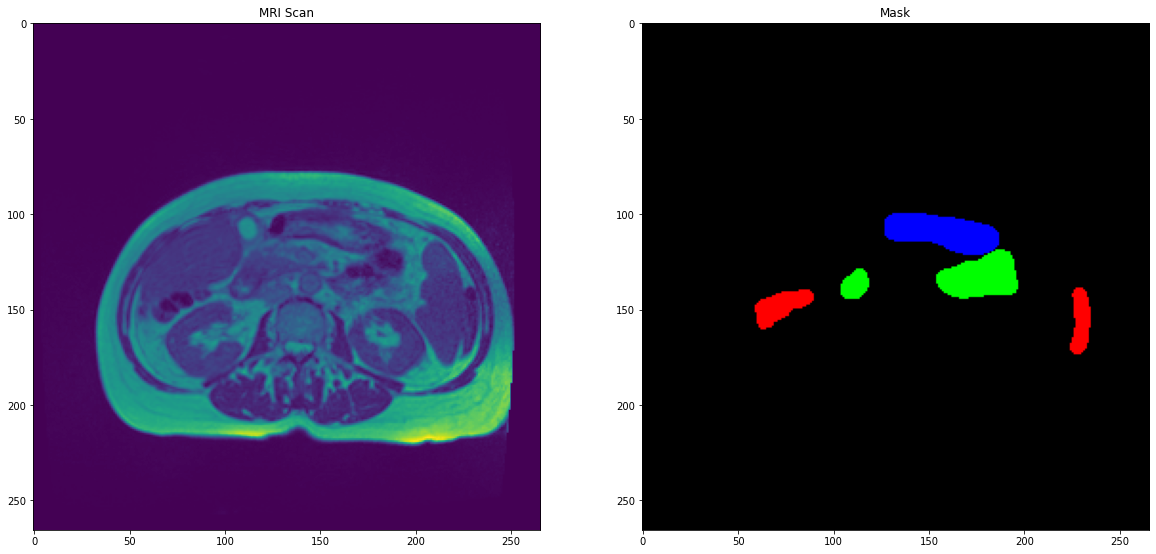

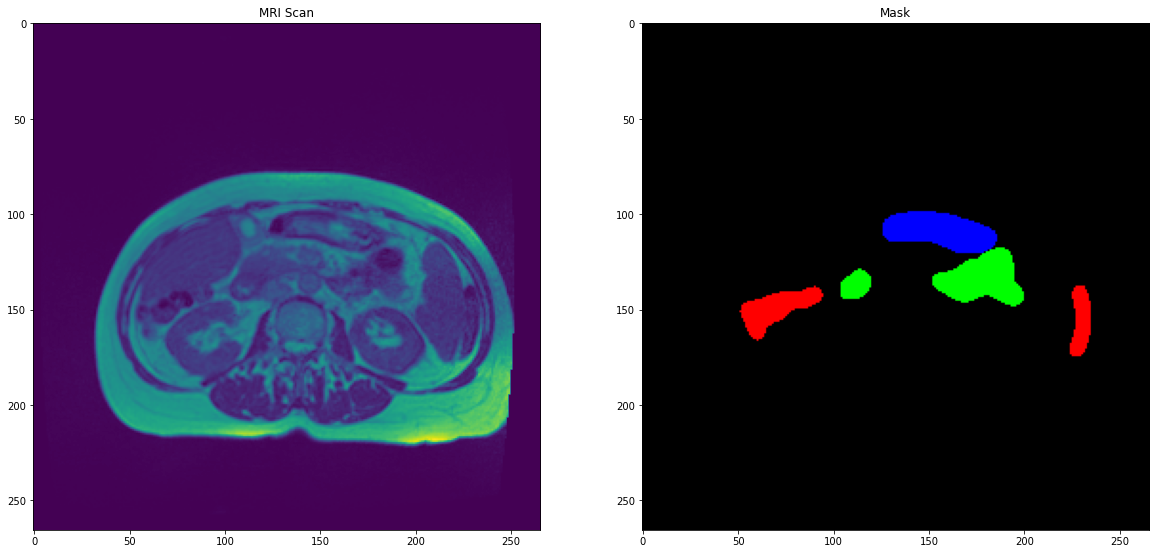

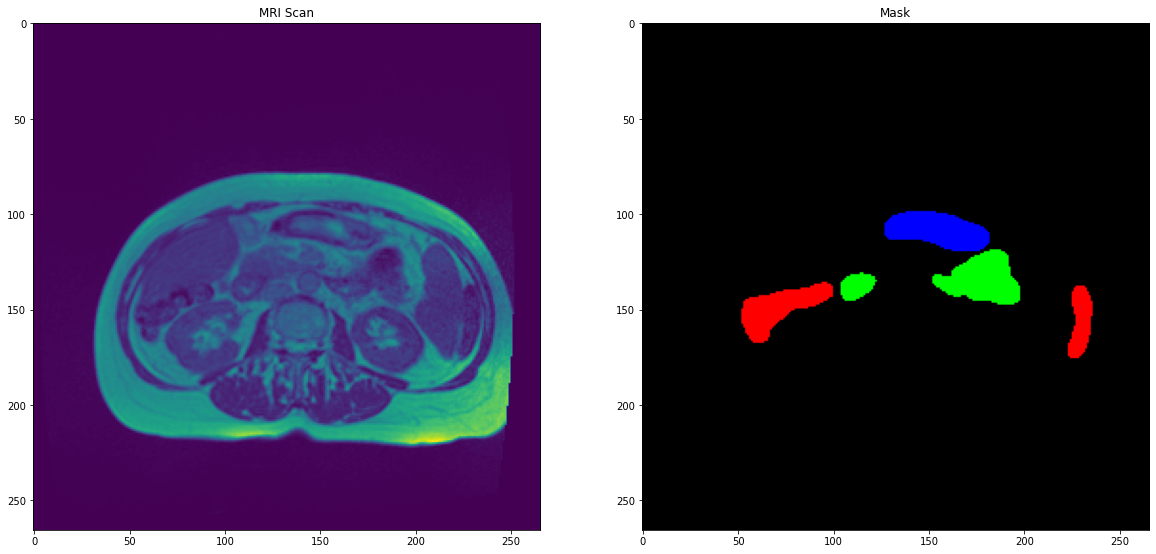

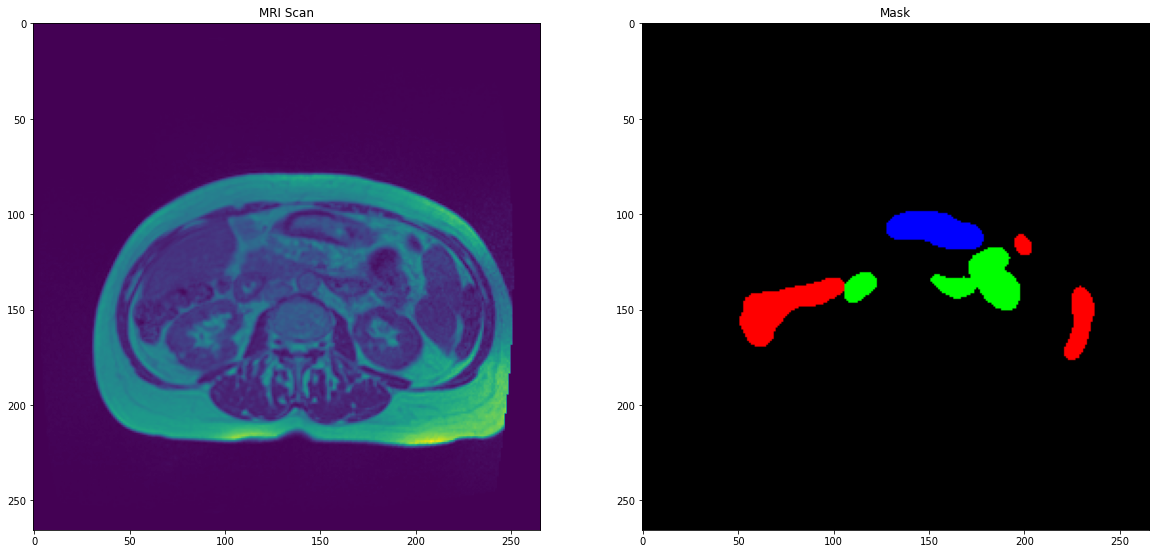

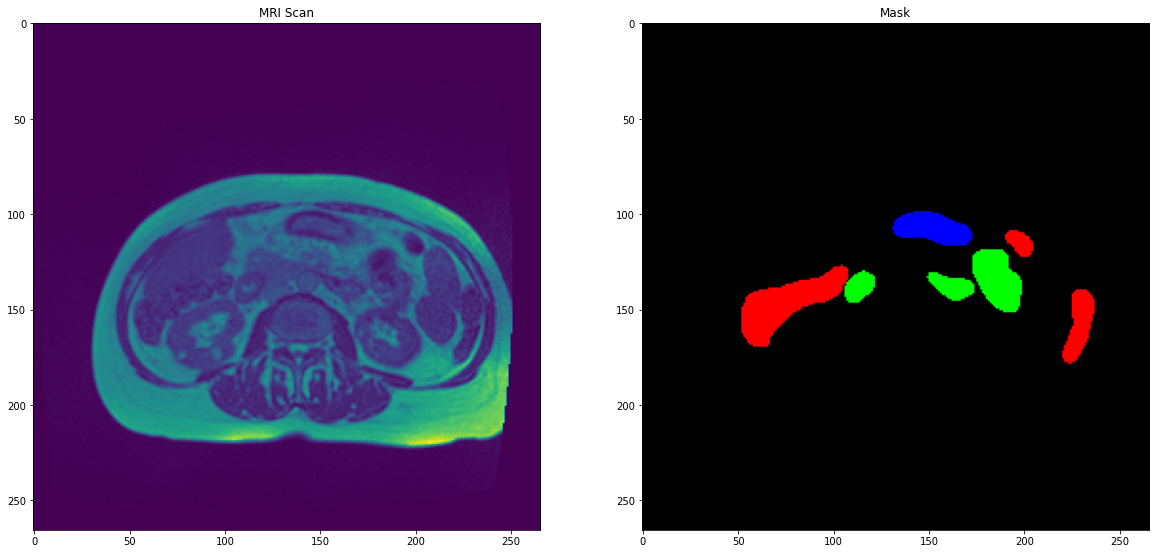

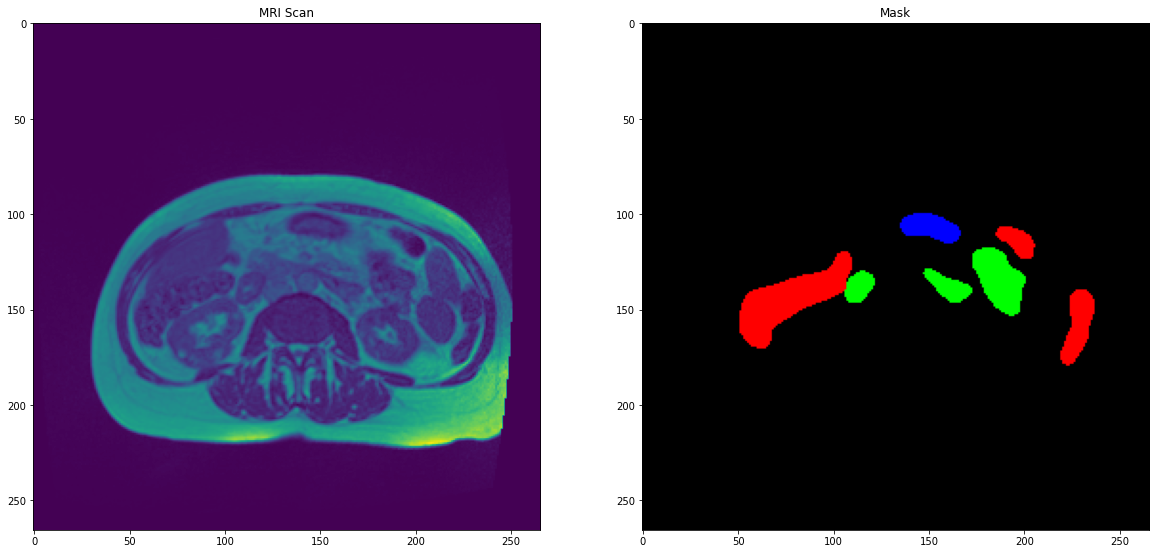

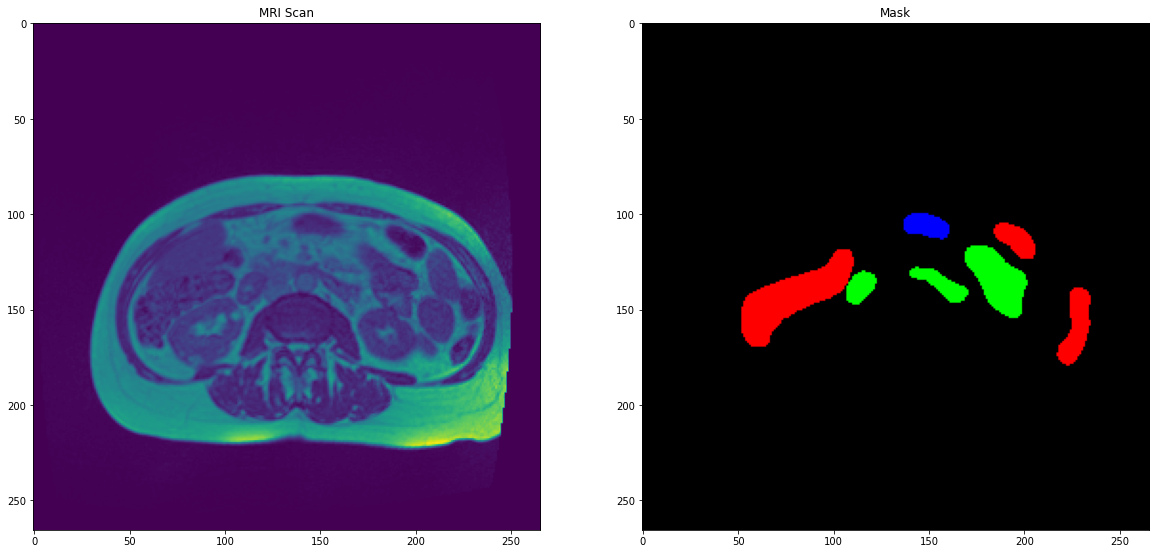

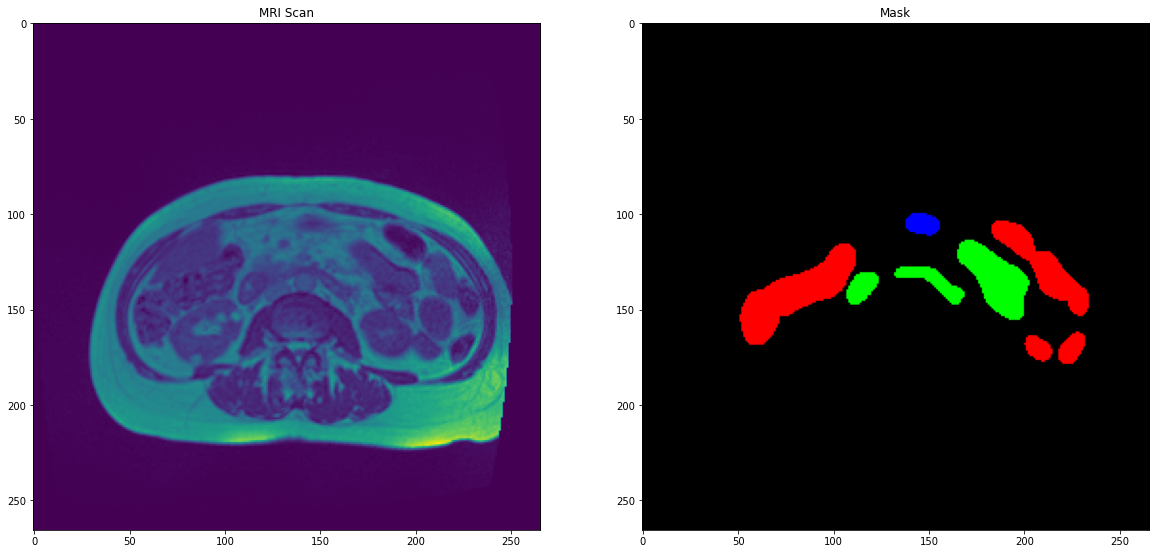

In [ ]:
for index in data[data['stomach'].notna()].tail(10).index:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(read_img(data.loc[index,'filepath']))
    plt.title("MRI Scan")
    plt.subplot(1,2,2)
    plt.imshow(RGBMask(data.loc[index,:]))
    plt.title("Mask")
    plt.show()